In [1]:
%tensorflow_version 2.x  

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from IPython.display import clear_output 

import tensorflow as tf 
from tensorflow import feature_column 

In [3]:
# Load data
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training dataset
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing dataset


y_train = dftrain.pop('survived') # pop survived column data from train and eval
y_eval = dfeval.pop('survived') 

In [4]:
# Observe and get to know structure and characteristics of data (Not Required to train Model)

# dftrain.describe() # prints out stats about data such as mean, std, etc.
dftrain.info() #prints out all the columns in data along with data type 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd35f3f9160>,
      dtype=object)

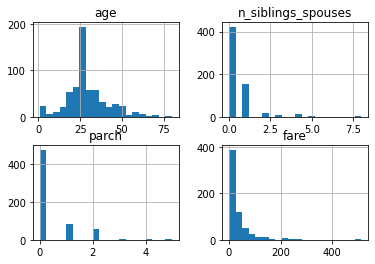

In [5]:
# Observe and get to know structure and characteristics of data (Not Required to train Model)
dftrain.hist(bins=20)

In [ ]:
# Observe and get to know structure and characteristics of data (Not Required to train Model)
dftrain['sex'].value_counts().plot(kind='bar')


In [ ]:
# Observe and get to know structure and characteristics of data (Not Required to train Model)
dftrain['class'].value_counts().plot(kind='bar')

In [ ]:
# setup features for model 
CATEGORICAL_COLUMNS = ['sex', 'class', 'deck', 'embark_town', 'alone']
NUMERICAL_COLUMNS = ['age', 'fare', 'n_siblings_spouses', 'parch']

feature_columns = [] 

# iterate through categorical columns
for feature_name in CATEGORICAL_COLUMNS: 
    vocabulary = dftrain[feature_name].unique() # get all the unique values for each category 
    feature = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary) # creates feature for a category given vocab 
    feature_columns.append(feature) 

# iterate through numerical columns 
for feature_name in NUMERICAL_COLUMNS: 
    feature = tf.feature_column.numeric_column(feature_name, dtype = tf.float32) # create a feature with float value
    feature_columns.append(feature) 

print(feature_columns)

In [9]:
# Add crossed feature columns 

#siblings_spouses_x_gender = tf.feature_column.crossed_column(['n_siblings_spouses', 'sex'], hash_bucket_size=100)
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)
class_x_gender = tf.feature_column.crossed_column(['class', 'sex'], hash_bucket_size = 100)
age_x_class = tf.feature_column.crossed_column(['age', 'class'], hash_bucket_size=100)

crossed_feature_columns = [age_x_gender, class_x_gender, age_x_class]

In [10]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # Nested function 
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  
  return input_function  

In [ ]:
# Run this to find the optimal number of epochs 
epochs=[50,100,150,200,250] #,275,300,350,400,500,600,700]
result_list=[]
max_epoch_accuracy = None, 0 

for epoch in epochs:
    train_input_fn = make_input_fn(dftrain,y_train,num_epochs=epoch)
    eval_input_fn = make_input_fn(dfeval,y_eval,num_epochs=1,shuffle=False)
    linear_est = tf.estimator.LinearClassifier(feature_columns= feature_columns+crossed_feature_columns)
    linear_est.train(train_input_fn)
    result = linear_est.evaluate(eval_input_fn)

    if result['accuracy'] > max_epoch_accuracy[1]: 
      max_epoch_accuracy = epoch, result['accuracy']

    result_list.append(result)

for i in range(len(epochs)):
      print("epoch:{},accuracy:{}".format(epochs[i],result_list[i]))

print('Number of epochs that yields highest accuracy, highest accuracy: ', max_epoch_accuracy)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxrwp8rj9/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.08411067


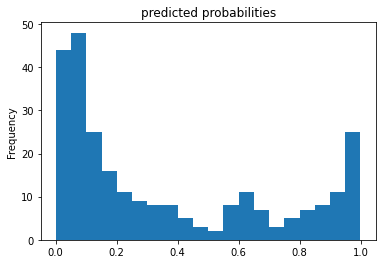

In [14]:
predictions = list(linear_est.predict(eval_input_fn)) # should be an object containing probabilities, class_ids...
print(predictions[0]['probabilities'][1])
probs = pd.Series([pred['probabilities'][1] for pred in predictions])
probs.plot(kind='hist', bins=20, title='predicted probabilities') # prints the predicted probabilties of survival and their frequency within the data set 
